## Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# To have the plots in the Jupyter notebook (not in separate window)  
%matplotlib inline

## Loading the data

In [2]:
file_folder = r'C:\Users\Atlantis\Documents\Jupyter\Titanic'
file_name1 = 'train.csv'
file_name2 = 'test.csv'

train_data = pd.read_csv(file_folder + '\\' + file_name1)
test_data = pd.read_csv(file_folder + '\\' + file_name2)

## Visualizing the data

In [3]:
print(train_data.head())
# print(train_data.shape)
# train_data.info() # maybe make a function that verifies the Nan values and say where they are ?
# train_data.describe()
# test_data.describe()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


## First impressions :

11 features and 1 output 'Survived'.  

### Missing values in :

* 'Age'

* 'Cabin'

* 'Embarked' 


### Ideas about the features :
'Sex' gives a good glance about the output (most women were saved)  
'Fare' is linked to/dependant of 'Embarqued' and 'Pclass'  
Maybe 'Pclass' and 'Embarked' are giving hints about the output (cabins next to rescue ships)  
'PassenderId' and 'Name' are likely uncorrelated with the output  
'Cabin' and 'Ticket' are just unintelligible strings  


## Classification of columns

In [4]:
col_num = ['Age','SibSp','Parch','Fare']
col_cat = ['Pclass','Sex','Embarked']

## Embarked imputation

In [5]:
def impute_embarked(df):
    
    '''
    Function that fills the Nan values of a dataframe which contains columns named
    'Embarked', 'Pclass' and 'Fare' and return the aformentioned dataframe.
    Using a max pool of passengers of same class with the same price +-5%
    '''
    
    df_imputable = df[df.Embarked.isnull()] # select only the rows with missing embarked values
    df_valid = df[~df.Embarked.isnull()]
    
    for i in df_imputable.index.to_list():
        Pclass_i = df_imputable.loc[i,'Pclass'] 
        fare_price_i = df_imputable.loc[i,'Fare']
        
        df_comparable_i = df_valid[(df_valid.Pclass == Pclass_i) & (df_valid.Fare > fare_price_i*0.95) & (df_valid.Fare < fare_price_i*1.05)]
        
        results_i = df_comparable_i.Embarked.value_counts()
        df.loc[i,'Embarked'] = results_i.index.to_list()[results_i.argmax()]
    
    return df
        
impute_embarked(train_data)
print('Is there still NaN Embarked values in train_data ? {}.'.format(train_data.Embarked.isnull().any()))

impute_embarked(test_data)
print('Is there still NaN Embarked values in test_data ? {}.'.format(test_data.Embarked.isnull().any()))

Is there still NaN Embarked values in train_data ? False.
Is there still NaN Embarked values in test_data ? False.


In [6]:
# Cabin imputation.... not so much data isn't it ? 204/891 
# maybe beter to delete
# impute cabin with Embarked and Pclass otherwise
# maybe make a function that combine printing and describing the data + which column can be deleted and which can be imputed easily

## Age imputation
Inspired by the article [The Search for Categorical Correlation](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9) from Toward Data Science by Shaked Zychlinski

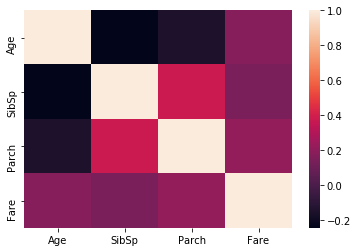

In [7]:
# Checking the links between numerical columns => Heatmap

whole_data_num = pd.concat([train_data[col_num],test_data[col_num]],axis = 0)
whole_data_num = whole_data_num.dropna()

corr = whole_data_num.corr()
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)

In [8]:
def correlation_ratio(category_values, numerical_values):

    '''
    Function that gives the correlation (eta) between a categorical variable and a numerical one.
    Uniques is a list used to track the names of the categories.
    Maybe using more numpy functions will make it faster...
    But it works fine like this !
    
    Inspired by the article 'The Search for Categorical Correlation' from Toward Data Science by Shaked Zychlinski
    
    category_values or x : pd.Series
    numerical_values or y : pd.Series
    '''
    
    cat_index , uniques = pd.factorize(category_values)
    uniques = uniques.to_list()
    cat_num = len(uniques)
    
    y_avg = pd.Series(0, index=range(0,cat_num))
    sample_num = pd.Series(0, index=range(0,cat_num))
    
    for i in range(0,cat_num):
        
        cat_measures_i = numerical_values[cat_index == i]
        sample_num[i] = len(cat_measures_i)
        y_avg[i] = cat_measures_i.mean() # mean of y for each category
                
    y_avg_tot = numerical_values.mean() # mean of y
    
    
    sum_square_between_group = ((y_avg-y_avg_tot).pow(2)*sample_num.values).sum()
    sum_square_tot = (numerical_values-y_avg_tot).pow(2).sum()

    eta = np.sqrt(sum_square_between_group/sum_square_tot)
    
    # Test made with values from the wikipedia page of correlation ratio
    # test_data = pd.DataFrame([['Al',45],['Geo',40],['Al',70],['Sta',65],['Al',29],['Sta',95],['Geo',20],['Geo',42],['Geo',30],['Al',15],['Al',21],['Sta',80],['Sta',70],['Sta',85],['Sta',73]])
    # correlation_ratio(test_data[0],test_data[1])
    
    # expected_sum_square_between_group = 6780
    # expected_sum_square_tot = 9640
    # expected_eta = 0.8386...
    
    return eta


       Age  variable       value
0     22.0    Pclass    Pclass_3
1     38.0    Pclass    Pclass_1
2     26.0    Pclass    Pclass_3
3     35.0    Pclass    Pclass_1
4     35.0    Pclass    Pclass_3
...    ...       ...         ...
3133   3.0  Embarked  Embarked_S
3134  37.0  Embarked  Embarked_Q
3135  28.0  Embarked  Embarked_S
3136  39.0  Embarked  Embarked_C
3137  38.5  Embarked  Embarked_S

[3138 rows x 3 columns]
Pclass      0
Sex         0
Embarked    0
dtype: int64


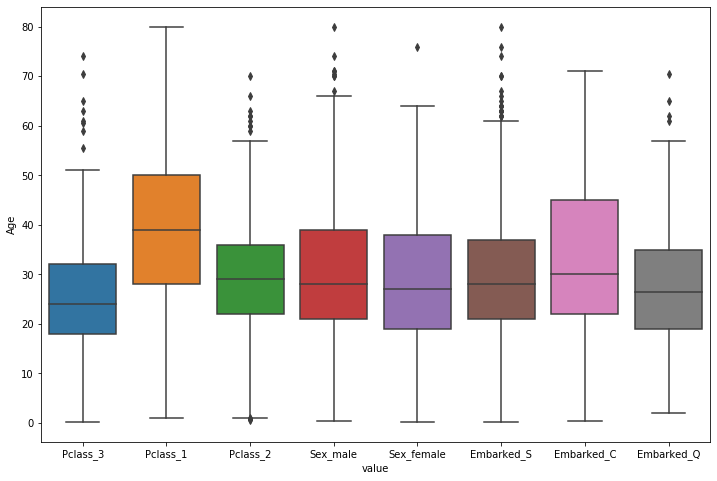

In [26]:
# Checking the links between categorical columns and Age => Boxplot and correlation ratio

col_cat_select = [c for c in col_cat if c not in {'Ticket','Cabin'}]

whole_data_cat = pd.concat([train_data[['Age']+col_cat_select],test_data[['Age']+col_cat_select]],axis = 0)
whole_data_cat = whole_data_cat.dropna()

# pd.melt is used to adapt the dataframe for the big plot
df_plot = pd.melt(whole_data_cat, id_vars=['Age'], value_vars=['Pclass', 'Sex', 'Embarked'])
df_plot.value = df_plot.variable.map(str) + '_' + df_plot.value.map(str)

plt.figure(figsize=(12,8))
sns.boxplot(x='value', y='Age', data = df_plot)
df_plot2 = pd.Series(0,index = whole_data_cat.drop(['Age'], axis=1).columns.to_list())

for i in df_plot2.index.to_list():
    df_plot2[i] = correlation_ratio(whole_data_cat[i],whole_data_cat['Age'])

print(df_plot2)

In [10]:
def entropy(x):
    
    '''
    Function that gives the Shanon Entropy of a panda serie.
    The entropy is maximal when the serie is totally random and is equal to log2(number of unique values)
    
    Inspired by the wikipedia page 'Entropy (Information Theory)'
    
    x : pd.Serie
    '''
    
    unique = x.value_counts()
    prob = unique/len(x) # creating a serie with the probalities of each unique outcomes of y
    en = prob.apply(lambda value: -value*np.log2(value)).sum() # log2 or just log ?
    
    # Test made with personal values
    # test_serie = pd.Series(['Undefined','France','Spain','Italy','France','France','Spain','Italy','France','Italy'])
    # entropy(test_serie)
    
    # expected_en = 1.8464
    
    return en

def j_entropy(x, y):
    
    '''
    Function that gives the Joint Entropy defined by the formula: 
    H(x,y) = entropy(x,y) where (x,y) is a pair of the values from x and y
    
    Inspired by the wikipedia page 'Joint Entropy'
    
    x: pd.Serie
    y: pd.Serie
    '''
    
    df = pd.concat([x,y],axis=1)
    df.columns = ['x','y']
    df['xy'] = df.x.astype(str)+df.y.astype(str) # creating the column that combine x and y values into a string 

    
    # Test made with personal values
    # test_serie_x = pd.Series(['Spain','France','Spain','Italy','France','France','Spain','Italy','France','Italy'])
    # test_serie_y =pd.Series(['Undefined','Red','Undefined','Red','Red','Red','Red','White','Red','White'])
    # j_entropy(test_serie_x,test_serie_y)
    
    # expected_j_en = 2.6464
    
    return entropy(df['xy'])

def c_entropy(x, y):
    
    '''
    Function that gives the Conditional Entropy of x knowing y defined by the formula :
    H(x|y) = H(x,y) - H(y)
    
    Inspired by the wikipedia page 'Conditional Entropy'
    
    x: pd.Serie
    y: pd.Serie
    '''
    
    return j_entropy(x, y) - entropy(y)

def theil_u(x, y):
    
    '''
    Function that gives the Theil's U or Uncertainty Coefficient.
    An asymmetric and useful measure based on the Shannon Entropy.
    Given by the formula :
    U(x|y) = [H(x)- H(x|y)]/H(x) 
    
    Inspired by the article 'The Search for Categorical Correlation' from Toward Data Science by Shaked Zychlinski
    
    x: pd.Serie
    y: pd.Serie
    '''
    
    s_xy = c_entropy(x,y)
    s_x = entropy(x)
    
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x
    
    # Test made by comparing the values of the heatmap obtained in the article using the code below on Kaggle:
    # df = pd.read_csv('mushrooms.csv')
    # df_theil = pd.DataFrame(0, index = df.columns, columns = df.columns)

    # for r in range(len(df.columns)):
    #      for c in range(len(df.columns)):
    #             df_theil.iloc[r,c] = theil_u(df.iloc[:,c],df.iloc[:,r]) # knowing the row can make the gessing of the column easier ?


    # plt.figure(figsize=(12,8))
    # sns.heatmap(df_theil,annot=True)    must make a test....

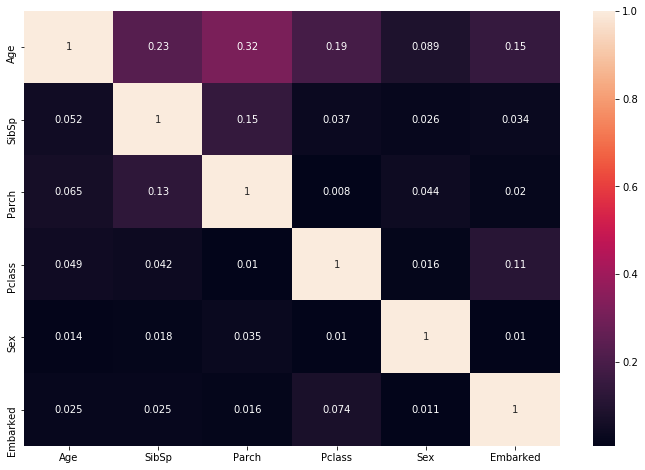

In [11]:
# Since the col num have integers (except 'Fare'), I will try another 'trick' showed
# in the article 'The Search for Categorical Correlation' from Toward Data Science by Shaked Zychlinski

col_theil = ['Age','SibSp','Parch','Pclass','Sex','Embarked']
whole_data_theil = pd.concat([train_data[col_theil],test_data[col_theil]],axis = 0)
whole_data_theil = whole_data_theil.dropna()
# whole_data_theil.Age = whole_data_theil.Age.apply(lambda a: round(a/10)*10) # categorizing the age values

# Heatmap of Theil's U:
df_theil = pd.DataFrame(0, index = col_theil, columns = col_theil)

for r in range(len(col_theil)):
    for c in range(len(col_theil)):
        df_theil.iloc[r,c] = theil_u(whole_data_theil.iloc[:,c],whole_data_theil.iloc[:,r]) # knowing the row can make the gessing of the column easier ?

plt.figure(figsize=(12,8))
sns.heatmap(df_theil, annot =True)

# sns.boxplot(x='Pclass', y='Age', hue='Embarked', data = whole_data_cat, palette = 'Accent')

# plt.figure(figsize=(12,8))
# df_plot2 = pd.melt(whole_data_cat, id_vars=['Pclass'], value_vars=['Embarked'])
# df_plot2.value = df_plot2.Pclass.map(str) + '_' + df_plot2.value.map(str)
# print(df_plot2)
# sns.countplot(df_plot2['value'])#nombre de personnes par Pclass en fonction*Embarqued
# % see segment bar plot and mosaic plot 


## Conclusion of age imputation

The feature 'Age' is moderately linked with the features 'SibSp', 'Parch' and 'Pclass'.  
However this link can be described as : "Knowing the age, we can infer the other variables" and not the other way around.  
'SibSp' and 'Parch' are correlated. 



We don't impute the age because it's correlated with nothing.  


## Feature creation

In [12]:
# Names
name_values = train_data.Name.values
res_list = []
for i in name_values :
    res = re.findall(r'\,.*?\.', i)
    res = res[0][2:-1] # pretifying the string detected
    res_list.append(str(res)) # re.findall gives a list of strings that needs to be converted to a string
    
print(set(res_list))

'''
Remarks:
There are 17 'titles' that can be used as a new categorical feature.
'''

def title(name_serie):
    
    '''
    Function that extracts the title from a formated list of names
    and gives back the list of titles (respecting the order from the list of names)
    using regex.
    
    name_serie: pd.Serie of strings where the title is between a coma and a point
    title_serie: pd.Serie of strings
    '''
    
    title_serie = pd.Series(0,range(len(name_serie)))
    
    for c in range(len(name_serie)):
        res = re.findall(r'\,.*?\.', name_serie[c])
        res = res[0][2:-1] # pretifying the string detected
        
        if res in ['Mr','Mrs','Miss','Mr','Mme','Mlle','Ms']:
            title_serie[c] = 0
        else:
            title_serie[c] = 1
    
    return title_serie 

train_data['Title'] = title(train_data.Name)
test_data['Title'] = title(test_data.Name)

{'Don', 'Col', 'Jonkheer', 'Major', 'Sir', 'Mrs', 'Master', 'Mlle', 'Mr', 'Dr', 'Mme', 'the Countess', 'Miss', 'Ms', 'Capt', 'Rev', 'Lady'}


## Gender model 
(or 'brute force' model)

In [13]:
def gender_model(df):
    df_pred = df[['PassengerId','Sex']]
    df_pred.columns = ['PassengerId','Survived']
    return df_pred.Survived.map(lambda s: int(s=='female'))

# sum(train_data.Survived == gender_model(train_data))/len(train_data)

## Remarks :
Score is 0.76555 on the test_data in kaggle.  
Score is 0.78676 on the train_data :-).  

The 'more advanced' models must perform better than this to be considered good for this problem.

## Random Forest model 
Inspired by the article [In Depth: Parameter tuning for Random Forest](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d) by M. Ben Fraj

Parameters estimation using the train data only
With AUC screening for n_estimators and max_depth


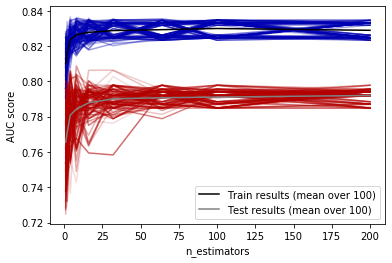

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

# Target
y = train_data["Survived"]

# Features
features = ["Pclass", "Sex", "SibSp", "Parch","Embarked","Title"]

# Splitting the data

from sklearn.model_selection import train_test_split

train_dummy = pd.get_dummies(train_data[features])

train_index, test_index = train_test_split(range(len(train_data)), test_size=0.25)

X_train = train_dummy.iloc[train_index,:]
X_test = train_dummy.iloc[test_index,:]
y_train = y[train_index]
y_test =y[test_index]

# Values of the parameters
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200] # numbers of trees (the more the better but can induce a significant lag)
max_depth = list(range(1,33)) # depth of the trees, a high depth means more branches and more information taken into account, but can lead to overfitting

# Choosing n_estimators

iterations = 100

train_results = np.zeros((iterations,len(n_estimators)))
test_results = np.zeros((iterations,len(n_estimators)))

for i in range(0,iterations):

    for n in range(len(n_estimators)):
        
        model = RandomForestClassifier(n_estimators=n_estimators[n],max_depth=10)
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_pred = model.predict(X_test)

# Plotting the AUC

        false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(y_train, y_train_pred)
        roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
        train_results[i,n] = roc_auc1

        false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(y_test, y_pred)
        roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
        test_results[i,n] = roc_auc2
    
    grad_blue = (0,0,0.7,((i+1)/(2*iterations)+0.1))
    grad_red = (0.7,0,0,((i+1)/(2*iterations)+0.1))
               
    plt.plot(n_estimators, train_results[i,:], color = grad_blue)
    plt.plot(n_estimators, test_results[i,:], color = grad_red)
    
mean_train_results = np.mean(train_results,axis=0)
mean_test_results = np.mean(test_results,axis=0)
plt.plot(n_estimators,mean_train_results,color=(0,0,0),label='Train results (mean over {})'.format(iterations))
plt.plot(n_estimators,mean_test_results,color=(0.5,0.5,0.5),label='Test results (mean over {})'.format(iterations))
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.legend()

plt.show()
# n_estimators = 32

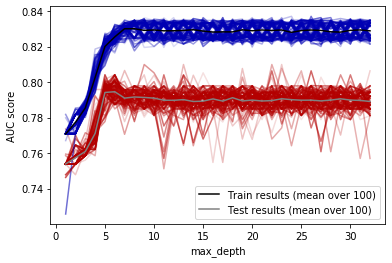

In [18]:
# Choosing max_depth with n_estimators = 32

train_results = np.zeros((iterations,len(max_depth)))
test_results = np.zeros((iterations,len(max_depth)))

for i in range(0,iterations):
    
    for d in range(len(max_depth)):
        
        model = RandomForestClassifier(n_estimators=32, max_depth = max_depth[d])
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_pred = model.predict(X_test)

# Plotting the AUC

        false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(y_train, y_train_pred)
        roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
        train_results[i,d] = roc_auc1

        false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(y_test, y_pred)
        roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
        test_results[i,d] = roc_auc2
    
    grad_blue = (0,0,0.7,((i+1)/(2*iterations)+0.1))
    grad_red = (0.7,0,0,((i+1)/(2*iterations)+0.1))
               
    plt.plot(max_depth, train_results[i,:], color = grad_blue)
    plt.plot(max_depth, test_results[i,:], color = grad_red)
    
mean_train_results = np.mean(train_results,axis=0)
mean_test_results = np.mean(test_results,axis=0)
plt.plot(max_depth,mean_train_results,color=(0,0,0),label='Train results (mean over {})'.format(iterations))
plt.plot(max_depth,mean_test_results,color=(0.5,0.5,0.5),label='Test results (mean over {})'.format(iterations))
plt.ylabel('AUC score')
plt.xlabel('max_depth')
plt.legend()

plt.show()
# max_depth=5

## Final models
With n_estimators = 32 and max_depth = 5  
Using different set of features.

Text(0, 0.5, 'AUC')

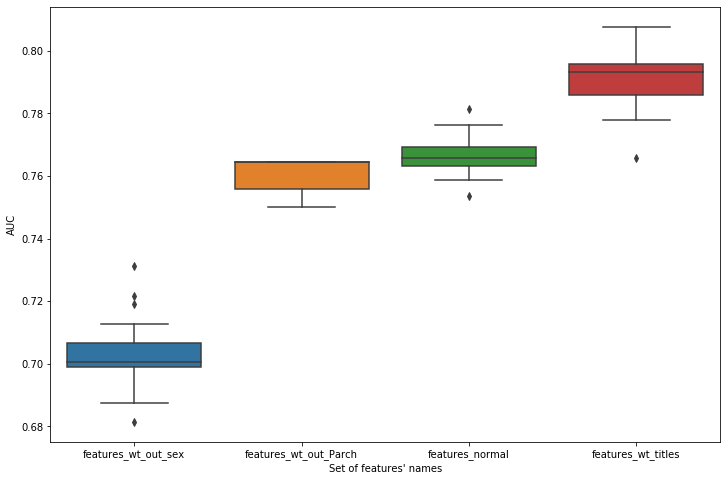

In [33]:
# Choosing the features

features_dict = {
  'features_wt_out_sex' : ["Pclass","SibSp","Parch","Embarked"],
  'features_wt_out_Parch' : ["Pclass", "Sex", "SibSp","Embarked"], 
  'features_normal' : ["Pclass", "Sex", "SibSp", "Parch","Embarked"],
  'features_wt_titles' : ["Pclass", "Sex", "SibSp", "Parch","Embarked","Title"]
}

test_results = np.zeros((iterations,len(features_dict.keys())))

for i in range(0,iterations):
        
    for d in range(0,len(features_dict.keys())):
        
        l = list(features_dict.keys())[d]
        features = features_dict[l]

# Restricting X_train and X_test according to the current feature list    

        filt_features = [col for col in X_train.columns.to_list() if col.startswith(tuple(features))]
        X_train_i = X_train[filt_features]
        X_test_i = X_test[filt_features]

        model = RandomForestClassifier(n_estimators=32, max_depth = 5)
        model.fit(X_train_i, y_train)
        y_train_pred = model.predict(X_train_i)
        y_pred = model.predict(X_test_i)
        
# Plotting the AUC of the test results to have an idea of the tendencies

        false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(y_test, y_pred)
        roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
        test_results[i,d] = roc_auc2
        

plt.figure(figsize=(12,8))
sns.boxplot(data = pd.DataFrame(data=test_results,columns=list(features_dict.keys())))
plt.xlabel("Set of features' names")
plt.ylabel("AUC")

In [ ]:
# https://towardsdatascience.com/6-amateur-mistakes-ive-made-working-with-train-test-splits-916fabb421bb
# https://towardsdatascience.com/interpretability-and-random-forests-4fe13a79ae34
# Part of the code where the hyperparameters are explained and where the predict file csv is saved
# explainabiolity of a rd forest view ???
model = RandomForestClassifier(n_estimators=32, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

# Train data accuracy (can lead to overfitting be careful)
# print('Accuracy on train data')
# print(sum(train_data.Survived.values == model.predict(pd.get_dummies(train_data[features])))/len(train_data))